IC conterfiet detection

In [ ]:
# Load dataset
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


PHASE 1 (TRAINING AND TESTING SEEN DATA) CODE PART


Using device: 
 cuda




Total number of files in dataset: 85

Number of training images: 68

Number of testing images: 17






/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet101_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet101-63fe2227.pth" to /root/.cache/torch/hub/checkpoints/resnet101-63fe2227.pth
100%|██████████| 171M/171M [00:00<00:00, 184MB/s]
/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.war










Epoch [1/10], Loss: 0.6449844241142273, Train Acc: 72.05882352941177%

Epoch [2/10], Loss: 0.5592373162508011, Train Acc: 89.70588235294117%

Epoch [3/10], Loss: 0.4415082484483719, Train Acc: 88.23529411764706%

Epoch [4/10], Loss: 0.2530246799190839, Train Acc: 89.70588235294117%

Epoch [5/10], Loss: 0.2095640692859888, Train Acc: 82.3529411764706%

Epoch [6/10], Loss: 0.44888908447076875, Train Acc: 83.82352941176471%

Epoch [7/10], Loss: 0.33393235007921857, Train Acc: 97.05882352941177%

Epoch [8/10], Loss: 0.19980053355296454, Train Acc: 92.6470588235294%

Epoch [9/10], Loss: 0.2183895626415809, Train Acc: 100.0%

Epoch [10/10], Loss: 0.09638120839372277, Train Acc: 98.52941176470588%











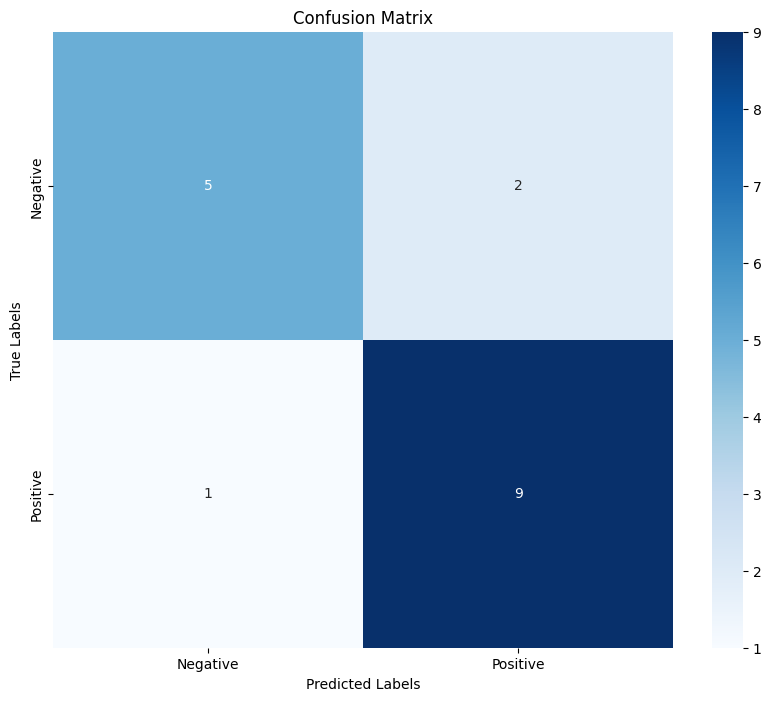

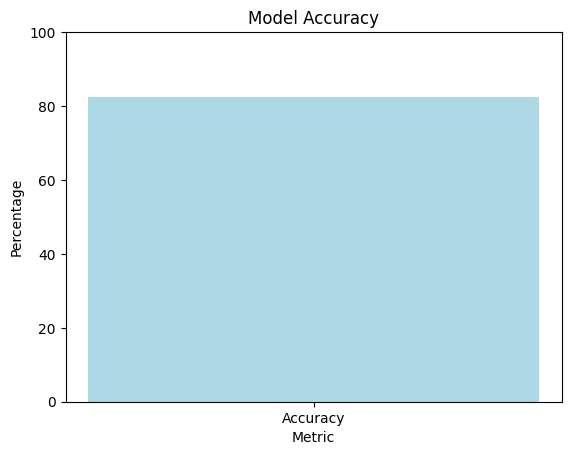








Confusion Matrix:
[[5 2]
 [1 9]]

True Positives: 9, True Negatives: 5, False Positives: 2, False Negatives: 1 


Model Accuracy: 0.82% 


Final test set accuracy: 82.35%

Model saved successfully!






/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet101_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, Subset
from torchvision import transforms, models
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from PIL import Image
from keras.models import load_model
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Set random seed for reproducibility
torch.manual_seed(64)
np.random.seed(64)

# Define computation device
compute_device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("\nUsing device: \n", compute_device)
print("\n\n")

class ImageDataset(Dataset):
    """ Custom dataset for loading images """
    def __init__(self, directory, transform=None):
        self.directory = directory
        self.transform = transform
        self.image_files = [file for file in os.listdir(directory) if os.path.isfile(os.path.join(directory, file))]
        self.image_labels = [1 if file.startswith('A') else 0 for file in self.image_files]

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, index):
        image_path = os.path.join(self.directory, self.image_files[index])
        image = Image.open(image_path).convert('RGB')
        label = self.image_labels[index]
        if self.transform:
            image = self.transform(image)
        return image, label

# Image transformations with augmentation
image_transforms = transforms.Compose([
    transforms.Resize((300, 300)),
    transforms.RandomRotation(10),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.CenterCrop(256),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load and prepare dataset
dataset_directory = '/content/drive/MyDrive/cv_vinay_project_2_dataset/train 2'
complete_dataset = ImageDataset(directory=dataset_directory, transform=image_transforms)
print(f'\nTotal number of files in dataset: {len(complete_dataset)}')

# Split dataset into training and testing
train_idx, test_idx = train_test_split(range(len(complete_dataset)), test_size=0.2, stratify=complete_dataset.image_labels)
training_data = Subset(complete_dataset, train_idx)
testing_data = Subset(complete_dataset, test_idx)

print(f'\nNumber of training images: {len(training_data)}')
print(f'\nNumber of testing images: {len(testing_data)}')

print("\n\n\n")

# Data loaders for batch processing
batch_size = 12
train_loader = DataLoader(training_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(testing_data, batch_size=batch_size, shuffle=False)

# Load and configure a pre-trained ResNet101 model
neural_network = models.resnet101(pretrained=True)
for param in neural_network.parameters():
    param.requires_grad = False  # Freeze all layers initially

# Unfreeze the last layer for fine-tuning
for param in neural_network.layer4.parameters():
    param.requires_grad = True

feature_count = neural_network.fc.in_features
neural_network.fc = nn.Linear(feature_count, 2)  # Adjust for binary classification
neural_network = neural_network.to(compute_device)

# Define loss function and optimizer
loss_function = nn.CrossEntropyLoss()
optimizer = optim.AdamW(neural_network.parameters(), lr=0.0001)
learning_rate_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.1, patience=10, verbose=True)

# Function to train the model
def train_network(network, data_loader, loss_fn, optim, lr_scheduler, epochs):
    """ Train the neural network """
    network.train()
    for epoch in range(epochs):  # Use the 'epochs' parameter in the loop
        total_loss = 0.0
        for images, labels in data_loader:
            images, labels = images.to(compute_device), labels.to(compute_device)
            optim.zero_grad()
            predictions = network(images)
            loss = loss_fn(predictions, labels)
            loss.backward()
            optim.step()
            total_loss += loss.item()
        lr_scheduler.step(calculate_accuracy(network, test_loader))
        training_accuracy = calculate_accuracy(network, train_loader)
        print(f'\nEpoch [{epoch+1}/{epochs}], Loss: {total_loss / len(train_loader)}, Train Acc: {training_accuracy}%')


print("\n\n\n")

# Function to calculate accuracy
def calculate_accuracy(network, loader):
    """ Calculate accuracy of the model """
    network.eval()
    correct_predictions = 0
    total_predictions = 0
    with torch.no_grad():
        for data in loader:
            images, labels = data
            images, labels = images.to(compute_device), labels.to(compute_device)
            outputs = network(images)
            _, predicted = torch.max(outputs.data, 1)
            total_predictions += labels.size(0)
            correct_predictions += (predicted == labels).sum().item()
    return 100 * correct_predictions / total_predictions

print("\n\n\n")
# Function to visualize performance
def visualize_performance(network, loader):
    """ Visualize performance of the model """
    network.eval()
    all_predictions = []
    all_true_labels = []
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(compute_device), labels.to(compute_device)
            outputs = network(images)
            _, preds = torch.max(outputs, 1)
            all_predictions.extend(preds.cpu().numpy())
            all_true_labels.extend(labels.cpu().numpy())

    print("\n\n\n\n\n")

    print("\n\n")
    confusion_mtx = confusion_matrix(all_true_labels, all_predictions)
    TN, FP, FN, TP = confusion_mtx.ravel()
    model_accuracy = (confusion_mtx.trace() / confusion_mtx.sum()) * 100
    plt.figure(figsize=(10, 8))
    sns.heatmap(confusion_mtx, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.show()


    model_accuracy = np.trace(confusion_mtx) / np.sum(confusion_mtx)
    plt.bar(['Accuracy'], [model_accuracy * 100], color='lightblue')
    plt.xlabel('Metric')
    plt.ylabel('Percentage')
    plt.title('Model Accuracy')
    plt.ylim([0, 100])
    plt.show()

    print("\n\n\n\n\n")

    print(f'\nConfusion Matrix:\n{confusion_mtx}')
    print(f'\nTrue Positives: {TP}, True Negatives: {TN}, False Positives: {FP}, False Negatives: {FN} \n')
    print(f'\nModel Accuracy: {model_accuracy:.2f}% \n')

    return model_accuracy

# Train and evaluate the model
train_network(neural_network, train_loader, loss_function, optimizer, learning_rate_scheduler, epochs=10)
final_model_accuracy = visualize_performance(neural_network, test_loader)
print(f'\nFinal test set accuracy: {final_model_accuracy * 100:.2f}%')

# Save the trained model
model_save_path = '/content/drive/MyDrive/model.h5'
torch.save(neural_network.state_dict(), model_save_path)
print("\nModel saved successfully!")
print("\n\n\n")
# Function to reload the model
def reload_network(model_path):
    """ Reload the trained model """
    reloaded_network = models.resnet101(pretrained=True)
    features = reloaded_network.fc.in_features
    reloaded_network.fc = nn.Linear(features, 2)
    reloaded_network.load_state_dict(torch.load(model_path))
    reloaded_network.to(compute_device)
    return reloaded_network

reloaded_model = reload_network(model_save_path)


PHASE 2 (TESTING UNSEEN DATA) CODE PART


 Using device: 
 cuda






/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


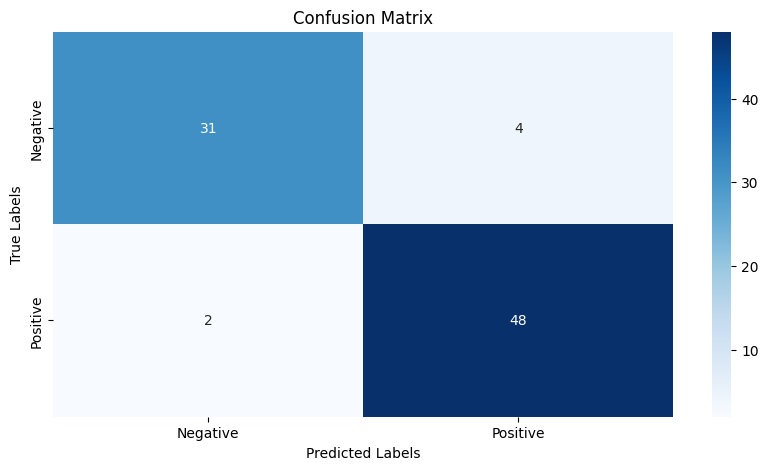


Confusion Matrix:
[[31  4]
 [ 2 48]]

True Positives: 48, True Negatives: 31, False Positives: 4, False Negatives: 2 


Model Accuracy: 92.94% 


Final Accuracy on Test Data: 92.94%



In [ ]:
import os
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Select the computation device based on availability
computation_device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("\n Using device: \n", computation_device)
print("\n\n\n")

class ImageDataLoader(Dataset):
    """ Custom dataset loader for handling various image formats. """
    def __init__(self, images_directory, image_transforms=None):
        self.images_directory = images_directory
        self.image_transforms = image_transforms
        self.image_paths = [os.path.join(images_directory, file_name) for file_name in os.listdir(images_directory)
                            if os.path.isfile(os.path.join(images_directory, file_name)) and file_name.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp'))]
        self.image_labels = [1 if 'A' in os.path.basename(file_name).split('_')[0] else 0 for file_name in self.image_paths]

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, index):
        path = self.image_paths[index]
        image = Image.open(path).convert('RGB')
        label = self.image_labels[index]
        if self.image_transforms:
            image = self.image_transforms(image)
        return image, label

# Enhanced image transformations for data augmentation
enhanced_transforms = transforms.Compose([
    transforms.Resize((300, 300)),
    transforms.RandomRotation(10),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.CenterCrop(256),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

def initialize_model(model_file_path):
    """ Load the pre-trained model from the specified path. """
    neural_network = models.resnet101(pretrained=False)
    features = neural_network.fc.in_features
    neural_network.fc = nn.Linear(features, 2)
    neural_network.load_state_dict(torch.load(model_file_path))
    neural_network.to(computation_device)
    neural_network.eval()
    return neural_network

def prepare_test_data(test_images_directory, image_transforms):
    """ Prepare the test data loader with the given transformations. """
    test_dataset = ImageDataLoader(images_directory=test_images_directory, image_transforms=image_transforms)
    test_data_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)
    return test_data_loader

def assess_model_performance(neural_network, data_loader):
    """ Evaluate the model's performance on the test data. """
    actual_labels = []
    predicted_labels = []
    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(computation_device), labels.to(computation_device)
            output = neural_network(images)
            _, predictions = torch.max(output, 1)
            predicted_labels.extend(predictions.cpu().numpy())
            actual_labels.extend(labels.cpu().numpy())

    print("\n\n")
    confusion_mtx = confusion_matrix(actual_labels, predicted_labels)
    TN, FP, FN, TP = confusion_mtx.ravel()
    model_accuracy = (confusion_mtx.trace() / confusion_mtx.sum()) * 100
    plt.figure(figsize=(10, 5))
    sns.heatmap(confusion_mtx, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.show()

    print(f'\nConfusion Matrix:\n{confusion_mtx}')
    print(f'\nTrue Positives: {TP}, True Negatives: {TN}, False Positives: {FP}, False Negatives: {FN} \n')
    print(f'\nModel Accuracy: {model_accuracy:.2f}% \n')
    return model_accuracy

if __name__ == "__main__":
    model_file_path = '/content/drive/MyDrive/project_cv_model.pth'
    test_images_directory = '/content/drive/MyDrive/CV_TEST_SAMPLE_DATASET/train 2' # test_unseen_datset

    neural_network = initialize_model(model_file_path)
    test_data_loader = prepare_test_data(test_images_directory, enhanced_transforms)

    accuracy_on_test_data = assess_model_performance(neural_network, test_data_loader)
    print(f"\nFinal Accuracy on Test Data: {accuracy_on_test_data:.2f}%\n")


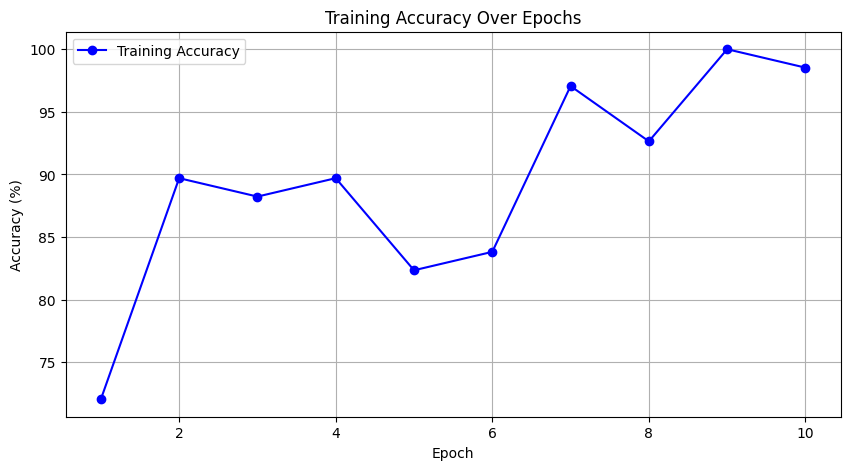

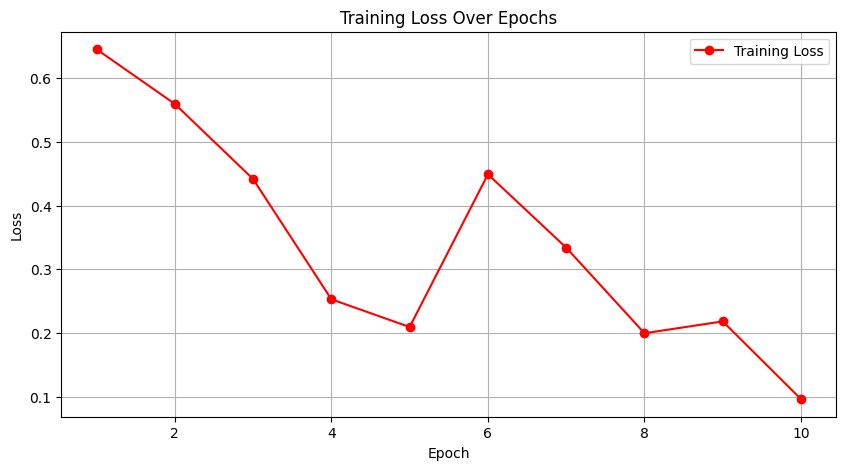

In [ ]:
import matplotlib.pyplot as plt

# Epoch data
epochs = list(range(1, 11))

# Accuracy data over epochs
accuracy = [
    72.05882352941177, 89.70588235294117, 88.23529411764706, 89.70588235294117,
    82.3529411764706, 83.82352941176471, 97.05882352941177, 92.6470588235294,
    100.0, 98.52941176470588
]

# Loss data over epochs
loss = [
    0.6449844241142273, 0.5592373162508011, 0.4415082484483719, 0.2530246799190839,
    0.2095640692859888, 0.44888908447076875, 0.33393235007921857, 0.19980053355296454,
    0.2183895626415809, 0.09638120839372277
]

# Plotting the Accuracy graph
plt.figure(figsize=(10, 5))
plt.plot(epochs, accuracy, marker='o', color='b', label='Training Accuracy')
plt.title('Training Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.grid(True)
plt.legend()

# Showing the plot
plt.show()

# Plotting the Loss graph
plt.figure(figsize=(10, 5))
plt.plot(epochs, loss, marker='o', color='r', label='Training Loss')
plt.title('Training Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()

# Showing the plot
plt.show()


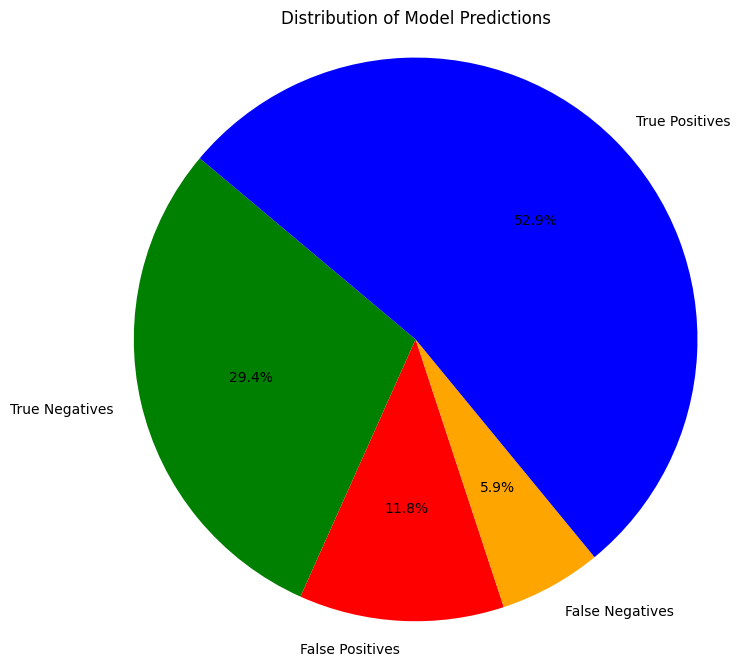

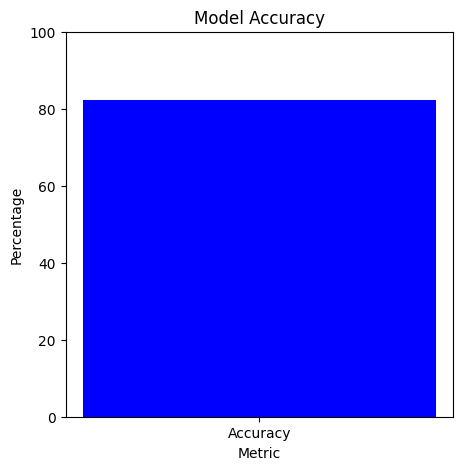

In [ ]:
import matplotlib.pyplot as plt

# Data from the confusion matrix
confusion_matrix = [[5, 2], [1, 9]]
true_negatives, false_positives, false_negatives, true_positives = confusion_matrix[0][0], confusion_matrix[0][1], confusion_matrix[1][0], confusion_matrix[1][1]

# Labels for the sections of our pie chart
labels = ['True Negatives', 'False Positives', 'False Negatives', 'True Positives']
sizes = [true_negatives, false_positives, false_negatives, true_positives]
colors = ['green', 'red', 'orange', 'blue']

# Creating the pie chart
plt.figure(figsize=(8, 8))
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140)
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.title('Distribution of Model Predictions')
plt.show()

# Creating a bar chart for model accuracy
accuracy = [82.35]  # Model accuracy percentage
metrics = ['Accuracy']

plt.figure(figsize=(5, 5))
plt.bar(metrics, accuracy, color='blue')
plt.xlabel('Metric')
plt.ylabel('Percentage')
plt.title('Model Accuracy')
plt.ylim(0, 100)
plt.show()


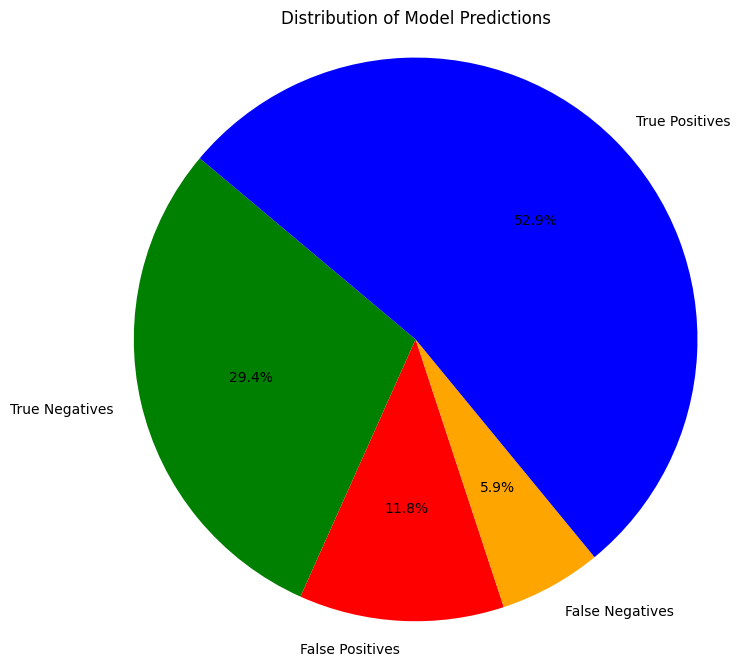

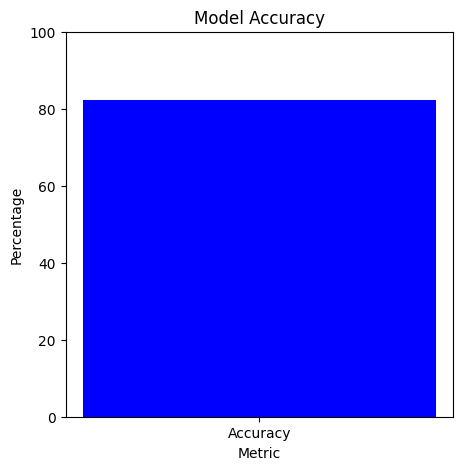

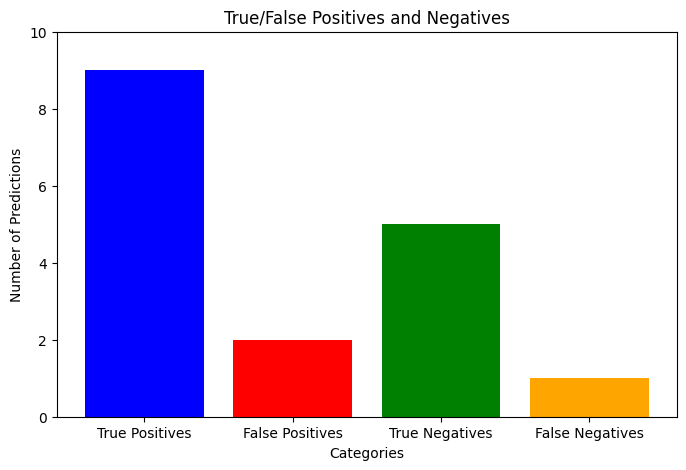

In [ ]:
import matplotlib.pyplot as plt

# Data from the confusion matrix
true_negatives, false_positives, false_negatives, true_positives = 5, 2, 1, 9

# Labels for the sections of our pie chart
labels = ['True Negatives', 'False Positives', 'False Negatives', 'True Positives']
sizes = [true_negatives, false_positives, false_negatives, true_positives]
colors = ['green', 'red', 'orange', 'blue']

# Creating the pie chart
plt.figure(figsize=(8, 8))
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140)
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.title('Distribution of Model Predictions')
plt.show()

# Creating a bar chart for model accuracy
accuracy = [82.35]  # Model accuracy percentage
metrics = ['Accuracy']

plt.figure(figsize=(5, 5))
plt.bar(metrics, accuracy, color='blue')
plt.xlabel('Metric')
plt.ylabel('Percentage')
plt.title('Model Accuracy')
plt.ylim(0, 100)
plt.show()

# Bar chart for True Positives, False Positives, True Negatives, False Negatives
tp_fp_tn_fn_values = [true_positives, false_positives, true_negatives, false_negatives]
tp_fp_tn_fn_labels = ['True Positives', 'False Positives', 'True Negatives', 'False Negatives']
colors = ['blue', 'red', 'green', 'orange']

plt.figure(figsize=(8, 5))
plt.bar(tp_fp_tn_fn_labels, tp_fp_tn_fn_values, color=colors)
plt.xlabel('Categories')
plt.ylabel('Number of Predictions')
plt.title('True/False Positives and Negatives')
plt.ylim(0, 10)
plt.show()

